# FASHION MNIST DATA CLASSIFICATION

## OSEMN Pipeline

I’ll be following a typical data science pipeline, which is call “OSEMN” (pronounced awesome).

**O**btaining the data is the first approach in solving the problem.

**S**crubbing or cleaning the data is the next step. This includes data imputation of missing or invalid data and fixing column names.


**E**xploring the data will follow right after and allow further insight of what our dataset contains. Looking for any outliers or weird data. Understanding the relationship each explanatory variable has with the response variable resides here and we can do this with a correlation matrix.


**M**odeling the data will give us our predictive power on whether an employee will leave.

I**N**terpreting the data is last. With all the results and analysis of the data, what conclusion is made? What factors contributed most to employee turnover? What relationship of variables were found?

## Obtaining the data & Scrubbing (cleaning) 

First import modules and laod data. Beause data is alread well preprocessed , There is no need to preprocessing

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from sklearn import model_selection

import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

import tensorflow as tf

In [2]:
train_df = pd.read_csv('./data/fashion-mnist_train.csv')
train_y = train_df['label']
train_x = train_df.xs(list(train_df.columns)[1:], axis=1)
train_x.apply( lambda x :(x - min(x))/ (max(x) - min(x)))

train_x, train_x_cv, train_y, train_y_cv = model_selection.train_test_split(train_x, train_y, train_size = 0.7)
del train_df 

## Exploring the data

In [3]:
print('Training data_set shape : ', train_x.shape)
print('CV_data_set shpape : ', train_x_cv.shape)
print('Training label shape: ', train_y.shape)
print("CV_label shape: ", train_y_cv.shape)
print()
print('The number of class : {}'.format(len(train_y.unique())))

Training data_set shape :  (42000, 784)
CV_data_set shpape :  (18000, 784)
Training label shape:  (42000,)
CV_label shape:  (18000,)

The number of class : 10


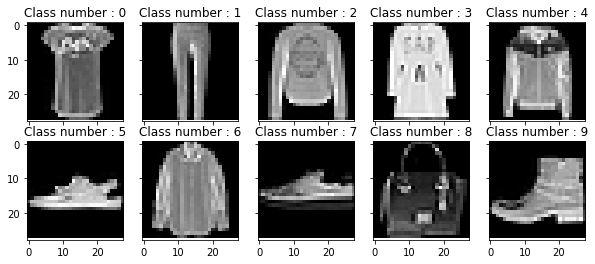

In [4]:
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10, 4))
ax = ax.flatten()

for label, ax_ in enumerate(ax):
    ax_.imshow(train_x[train_y==label].sample(1).values.reshape(28,28) ,cmap='gray')
    ax_.set_title('Class number : {}'.format(label))

Random sampled image that is extracted from each class. There are 10 distinct classes.

## Build Model

In [5]:
class ConvNet(object):
    
    def __init__(self, features, labels, hp, scope, reuse =False):
        
        self.features = tf.cast(tf.reshape(features,shape = [-1, 28, 28, 1]), tf.float32)
        self.labels = tf.cast(labels, tf.int64)                
        
        with tf.variable_scope(scope, reuse = reuse):
            
            with tf.variable_scope('Conv1'):
                # Now 28 x 28 x 32
                self.conv1 = tf.layers.conv2d(self.features, 32, kernel_size=(5,5), strides=(2,2), padding='same', activation=tf.nn.relu, name='conv1')

            with tf.variable_scope('Conv2'):
                # Now 14 x 14 x 64
                self.conv2 = tf.layers.conv2d(self.conv1, 64, kernel_size=(2,2), strides=2, name='conv2')
                # Now 8 x 8  x 64
                self.pool2 = tf.layers.max_pooling2d(self.conv2, pool_size=(2,2), strides=2, padding='same', name='pool2')
                self.out2 = tf.nn.relu(self.pool2, name='out2')
                # Now  4 x 4 x 64

            with tf.variable_scope('Flatten'):
                self.flat = tf.layers.flatten(self.out2, name='flat')
                # Now 4*4*64

            with tf.variable_scope('Train'):
                self.learning_rate = tf.placeholder(tf.float32, name ='learning_rate')
                self.logits = tf.layers.dense(self.flat, hp['num_labels'], 
                                              kernel_initializer = tf.truncated_normal_initializer(stddev=0.1),name='logits')
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(self.labels, hp['num_labels']), logits=self.logits))
                self.global_step = tf.Variable(0, trainable=False, name ='global_step')
                self.train_op = tf.train.AdagradOptimizer(self.learning_rate).minimize(self.loss, global_step = self.global_step)

            with tf.variable_scope('Eval'):
                self.prediction = tf.argmax(self.logits, axis=1, name='prediction')
                self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.labels), tf.float32), name= 'accuracy')
            
            tf.summary.scalar('Accuray', self.accuracy)
            tf.summary.scalar('Loss', self.loss)            
#             tf.summary.histogram('Flat', self.flat)            
            self.merge = tf.summary.merge_all()

## Define Hyperparameters

In [6]:
hp = {}

hp['num_labels'] = 10
hp['num_batch'] = 64
hp['epoch_restored'] = 45
hp['epoch'] = 60
hp['leraning_rate'] = 0.1 # will be decayed

## Build Datasets_for train

In [ ]:
tf.reset_default_graph()

training_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
training_dataset  = training_dataset.batch(hp['num_batch']).repeat(1).shuffle(1000)
eval_dataset = tf.data.Dataset.from_tensor_slices((train_x_cv, train_y_cv))
eval_dataset = eval_dataset.batch(len(train_x_cv)).repeat(1)

iterator = tf.data.Iterator.from_structure(training_dataset.output_types)

train_init_op = iterator.make_initializer(training_dataset)
eval_init_op = iterator.make_initializer(eval_dataset)

features, labels = iterator.get_next()

Model = ConvNet(features, labels, hp, 'ConvNet')

save_var = tf.global_variables()
saver = tf.train.Saver(save_var, max_to_keep=2)

## Train The Model

In [ ]:
with tf.Session() as sess:
        
    sess.run([train_init_op, tf.global_variables_initializer()])
    file_writer = tf.summary.FileWriter('./logs/training', sess.graph)
    file_writer_cv = tf.summary.FileWriter('./logs/test', sess.graph)

#     saver.restore(sess, tf.train.latest_checkpoint('./ckpt'))    
#     print('Graph is loaded')
#     sess.run(iterator.initializer)            
    
    for e in tqdm(range(hp['epoch_restored'], hp['epoch']+1), total=1 + hp['epoch'] - hp['epoch_restored'], ncols = 20):        
        
        hp['learning_rate'] = 0.0001
        
        while True:
            try:                
                sess.run(Model.train_op, feed_dict = {Model.learning_rate : hp['learning_rate']})

            except tf.errors.OutOfRangeError:

                if e % 5 == 0: 
                    saver.save(sess, './ckpt/{}_epoch'.format(e))                                                
                    
                sess.run(eval_init_op)                    
                merge, step = sess.run([Model.merge, Model.global_step], feed_dict = {Model.learning_rate : hp['learning_rate']})
                file_writer_cv.add_summary(merge, step)
                                                                                                                                                                                                            
                sess.run(train_init_op)
                merge, _ = sess.run([Model.merge, Model.train_op], feed_dict = {Model.learning_rate : hp['learning_rate']})
                file_writer.add_summary(merge, step)
                break

 12%|▏| 2/16 [01:08<08:00, 34.32s/it]

## Training / Crossvalidation  - Accuracy / Loss (tensorboard)

![Accuracy](img/Accuracy.PNG)
![Loss](img/Loss.PNG)

About 90% Accuracy is gaind. Because this Model is underfitted , it can be improved using small learning rate and iterating more steps

# Restart the Notebook

### Restore Model to Prediction( Test set )

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
class ConvNet(object):
    
    def __init__(self, features, labels, hp, scope, reuse =False):
        
        self.features = tf.cast(tf.reshape(features,shape = [-1, 28, 28, 1]), tf.float32)
        self.labels = tf.cast(labels, tf.int64)                
        
        with tf.variable_scope(scope, reuse = reuse):
            
            with tf.variable_scope('Conv1'):
                # Now 28 x 28 x 32
                self.conv1 = tf.layers.conv2d(self.features, 32, kernel_size=(5,5), strides=(2,2), padding='same', activation=tf.nn.relu, name='conv1')

            with tf.variable_scope('Conv2'):
                # Now 14 x 14 x 64
                self.conv2 = tf.layers.conv2d(self.conv1, 64, kernel_size=(2,2), strides=2, name='conv2')
                # Now 8 x 8  x 64
                self.pool2 = tf.layers.max_pooling2d(self.conv2, pool_size=(2,2), strides=2, padding='same', name='pool2')
                self.out2 = tf.nn.relu(self.pool2, name='out2')
                # Now  4 x 4 x 64

            with tf.variable_scope('Flatten'):
                self.flat = tf.layers.flatten(self.out2, name='flat')
                # Now 4*4*64

            with tf.variable_scope('Train'):
                self.learning_rate = tf.placeholder(tf.float32, name ='learning_rate')
                self.logits = tf.layers.dense(self.flat, hp['num_labels'], 
                                              kernel_initializer = tf.truncated_normal_initializer(stddev=0.1),name='logits')
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(self.labels, hp['num_labels']), logits=self.logits))
                self.global_step = tf.Variable(0, trainable=False, name ='global_step')
                self.train_op = tf.train.AdagradOptimizer(self.learning_rate).minimize(self.loss, global_step = self.global_step)

            with tf.variable_scope('Eval'):
                self.prediction = tf.argmax(self.logits, axis=1, name='prediction')
                self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.labels), tf.float32), name= 'accuracy')
            
            tf.summary.scalar('Accuray', self.accuracy)
            tf.summary.scalar('Loss', self.loss)            
            tf.summary.histogram('Flat', self.flat)            
            self.merge = tf.summary.merge_all()

In [3]:
hp = {}

hp['num_labels'] = 10
hp['num_batch'] = 64
hp['epoch_restored'] = 54
hp['epoch'] = 60
hp['leraning_rate'] = 0.1 # will be decayed

In [4]:
tf.reset_default_graph()

test_df = pd.read_csv('./data/fashion-mnist_test.csv')
test_x = test_df.xs(list(test_df.columns)[1:], axis=1)
test_y = test_df['label']
del test_df

test_x.apply( lambda x :(x - min(x))/ (max(x) - min(x)))
dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
dataset  = dataset.batch(len(test_y)).repeat(1)
iterator = dataset.make_initializable_iterator()
inputs = iterator.get_next()

features, labels = inputs
Model = ConvNet(features, labels, hp, 'ConvNet')

save_var = tf.global_variables()
saver = tf.train.Saver(save_var)

In [64]:
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('./ckpt'))
    sess.run(iterator.initializer)
    
    while True:        
        try:                
            prediction, loss, accuracy = sess.run([Model.prediction, 
                                                   Model.loss, 
                                                   Model.accuracy], 
                                                  feed_dict = {Model.learning_rate : hp['leraning_rate']})
            
            print('Loss : {} | Test_Accuracy : {}'.format(loss, accuracy))

        except tf.errors.OutOfRangeError:                      
            break

INFO:tensorflow:Restoring parameters from ./ckpt\58_epoch
Loss : 0.35807910561561584 | Test_Accuracy : 0.8787000179290771


In [80]:
def show_wrong_examples(test_x, test_y, prediction, n=5):
    wrong_idx = (test_y != prediction)
    wrong_x = test_x[wrong_idx]
    wrong_y = test_y[wrong_idx]
    wrong_pred_y = prediction[wrong_idx]
    df = pd.DataFrame({'pred' : wrong_pred_y}, index=wrong_y.index).join(wrong_y).join(wrong_x)

    sample = df.sample(n)
    fig, axes = plt.subplots(n,3, figsize = (6, 2*n))
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        if idx % 3 == 0:
            ax.imshow(sample.xs(df.columns[2:],axis=1).iloc[int(idx/3)].reshape(28,28), cmap='gray')
            ax.set_title('True/Pred : {} / {}'.format(sample.label.iloc[int(idx/3)], sample.pred.iloc[int(idx/3)]))
            ax.axis('off')

        elif idx %3 == 2:
            ax.imshow(test_x[test_y==sample.pred.iloc[int(idx/3)]].sample(1).values.reshape(28,28), cmap='gray')
            ax.set_title('True {} Class'.format(sample.pred.iloc[int(idx/3)]))
            ax.axis('off')

        elif idx %3 == 1:
            ax.imshow(test_x[test_y==sample.label.iloc[int(idx/3)]].sample(1).values.reshape(28,28), cmap='gray')
            ax.set_title('True {} Class'.format(sample.label.iloc[int(idx/3)]))
            ax.axis('off')

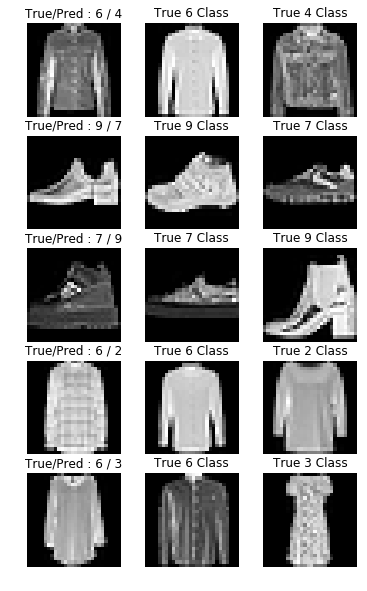

In [87]:
show_wrong_examples(test_x, test_y, prediction, 5)